# Team Cyberwise
## Cyber Fraud Detection Automata - v2
### (Tailor-made for SMEs, open source, speed + scalability + quality of prediction)

In [2]:
# this algorithm reads in logs files, automates the formatting, 
#classifies behaviors of false alarms vs. real threats, and develops an ML-model for prediction

In [1]:
rm(list=(ls()))
R.version.string

[1] "R version 4.0.2 (2020-06-22)"

In [2]:
install.packages('fastDummies')

Installing package into 'C:/Users/Faiz/Documents/R/win-library/4.0'
(as 'lib' is unspecified)



package 'fastDummies' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\Faiz\AppData\Local\Temp\Rtmpiw34ja\downloaded_packages


In [128]:
#used/tobeused packages here
library(tidyverse)
library(ggplot2)
library(fastDummies)
library(e1071)
library(caret)

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [4]:
# read log
log <- read.csv("logs.csv")

### Data Engineering Steps

In [6]:
head(log)

,Oct,X21,X12.05.28.AM,cyberwise,haproxy.21587..,X24.99.108.59.36460,X.21.Oct.2020.00.05.28.457.,public,public..NOSRV.,X.1..1..1..1.0,X503,X213,X.,X..1,SC..,X1.1.0.0.0,X0.0,X.GET,X..2,HTTP.1.1.
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Oct,21,12:15:23 AM,cyberwise,haproxy[21587]:,44.234.61.1:36022,[21/Oct/2020:00:15:23.341],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.1"""
2,Oct,21,12:51:45 AM,cyberwise,haproxy[21587]:,220.135.248.121:34347,[21/Oct/2020:00:51:45.406],public,public/<NOSRV>,-1/-1/-1/-1/320,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.1"""
3,Oct,21,1:25:08 AM,cyberwise,haproxy[21587]:,185.39.11.105:54214,[21/Oct/2020:01:25:08.125],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""POST",/editBlackAndWhiteList,"HTTP/1.1"""
4,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:50872,[21/Oct/2020:01:28:15.803],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/w00tw00t.at.blackhats.romanian.anti-sec:),"HTTP/1.1"""
5,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:50996,[21/Oct/2020:01:28:15.900],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/phpMyAdmin/scripts/setup.php,"HTTP/1.1"""
6,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:51140,[21/Oct/2020:01:28:15.996],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/phpmyadmin/scripts/setup.php,"HTTP/1.1"""


In [10]:
summary(log)

     Oct                X21            X12.05.28.AM        cyberwise        
 Length:73360       Length:73360       Length:73360       Length:73360      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
 haproxy.21587..    X24.99.108.59.36460 X.21.Oct.2020.00.05.28.457.
 Length:73360       Length:73360        Length:73360               
 Class :character   Class :character    Class :character           
 Mode  :character   Mode  :character    Mode  :character           
    public          public..NOSRV.     X.1..1..1..1.0         X503          
 Length:73360       Length:73360       Length:73360       Length:73360      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
     X213                X.                X..1               SC..          
 Length:73360       Length:73360   

In [12]:
names(log)

[1] "Oct"                         "X21"                        
 [3] "X12.05.28.AM"                "cyberwise"                  
 [5] "haproxy.21587.."             "X24.99.108.59.36460"        
 [7] "X.21.Oct.2020.00.05.28.457." "public"                     
 [9] "public..NOSRV."              "X.1..1..1..1.0"             
[11] "X503"                        "X213"                       
[13] "X."                          "X..1"                       
[15] "SC.."                        "X1.1.0.0.0"                 
[17] "X0.0"                        "X.GET"                      
[19] "X..2"                        "HTTP.1.1."

In [13]:
nrow(log)

[1] 73360

In [15]:
#there are some gaps in column 2 (what should be day), need to clean these up - doing in quattro reading in new file

In [4]:
# read log
log1 <- read.csv("logs_clean.csv")

In [5]:
nrow(log1)

[1] 53956

In [6]:
#number of rows looks better now
ncol(log1)

[1] 20

In [7]:
#label the columns better
names(log1) <- c("month", "day", "time", "source", "proxy", "ipaddress","timestamp","public","service","seq1","data1","data2",
                "ignore1","ignore2","label1","seq2","seq3","action","note","http")
head(log1)

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,data1,data2,ignore1,ignore2,label1,seq2,seq3,action,note,http
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Oct,21,12:15:23 AM,cyberwise,haproxy[21587]:,44.234.61.1:36022,[21/Oct/2020:00:15:23.341],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.1"""
2,Oct,21,12:51:45 AM,cyberwise,haproxy[21587]:,220.135.248.121:34347,[21/Oct/2020:00:51:45.406],public,public/<NOSRV>,-1/-1/-1/-1/320,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.1"""
3,Oct,21,1:25:08 AM,cyberwise,haproxy[21587]:,185.39.11.105:54214,[21/Oct/2020:01:25:08.125],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""POST",/editBlackAndWhiteList,"HTTP/1.1"""
4,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:50872,[21/Oct/2020:01:28:15.803],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/w00tw00t.at.blackhats.romanian.anti-sec:),"HTTP/1.1"""
5,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:50996,[21/Oct/2020:01:28:15.900],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/phpMyAdmin/scripts/setup.php,"HTTP/1.1"""
6,Oct,21,1:28:15 AM,cyberwise,haproxy[21587]:,89.248.174.11:51140,[21/Oct/2020:01:28:15.996],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/phpmyadmin/scripts/setup.php,"HTTP/1.1"""


In [8]:
unique(log1[["month"]])

[1] "Oct"               "Sep"               "you"              
 [4] ":"                 "fetch"             "1"                
 [7] "'replace-header'," "'sc-inc-gpc0(*)'," "active"           
[10] "backup"            "key"               "from"

In [9]:
oct <- filter(log1, month == "Oct")
sep <- filter(log1, month == "Sep")
other <- filter(log1, month !="Oct", month != "Sep" )
nrow(oct)

[1] 23529

In [42]:
nrow(sep)

[1] 30345

In [50]:
nrow(other)

[1] 82

In [51]:
other

month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,data1,data2,ignore1,ignore2,label1,seq2,seq3,action,note,http
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
you,should,set,it,to,at,least,2048,Please,set,a,value,>=,1024,to,make,this,warning,disappear.,
:,no,such,ACL,:,'auth_ok'.,,,,,,,,,,,,,,
:,no,such,ACL,:,'auth_ok'.,,,,,,,,,,,,,,
you,should,set,it,to,at,least,2048,Please,set,a,value,>=,1024,to,make,this,warning,disappear.,
fetch,method,http_auth_admin,in,ACL,expression,'http_auth_admin(admin)'.,,,,,,,,,,,,,
:,no,such,ACL,:,'auth_okay_admin'.,,,,,,,,,,,,,,
fetch,method,http_auth_admin,in,ACL,expression,'http_auth_admin(admin)'.,,,,,,,,,,,,,
:,no,such,ACL,:,'auth_okay_admin'.,,,,,,,,,,,,,,
1,of,ACL,keyword,,in,proxy,'git_server'.,,,,,,,,,,,,


In [ ]:
# the 'other' dataset is some notes and does not contain useful ip or web traffice info, will delete it (i.e. only focus on the oct and sep data frames)

In [52]:
#some stats on sep / oct dataset

In [60]:
head(sep)

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,data1,data2,ignore1,ignore2,label1,seq2,seq3,action,note,http
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Sep,23,12:06:14 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:06:14.331],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.0"""
2,Sep,23,12:11:03 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:11:01.638],public/2:,SSL,handshake,failure,,,,,,,,,
3,Sep,23,12:25:57 AM,cyberwise,haproxy[18755]:,170.82.48.12:42622,[23/Sep/2020:00:25:57.296],public/2:,SSL,handshake,failure,,,,,,,,,
4,Sep,23,12:48:33 AM,cyberwise,haproxy[18755]:,181.143.101.194:33327,[23/Sep/2020:00:48:33.326],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""POST",/cgi-bin/ViewLog.asp,"HTTP/1.1"""
5,Sep,23,12:55:20 AM,cyberwise,haproxy[18755]:,45.148.10.28:44932,[23/Sep/2020:00:55:20.249],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/config/getuser?index=0,"HTTP/1.1"""
6,Sep,23,12:58:48 AM,cyberwise,haproxy[18755]:,193.40.241.27:45505,[23/Sep/2020:00:58:47.771],public~,mail_server/srv01,0/0/1/284/286,200,842,-,-,--NN,1/1/0/0/0,0/0,"""POST",/?/Ajax/&q[]=/_4wXiFYfqwmL7Nwr2QroCHSM_NzyufG_GfkV-Fm-eF5HYhgDpoeVKOXBnvGiF_cEcq5ftapqlmnQkaIua8yULfJ9TgPwuKJ0dpU4SO00CWn7F1RTydBISZMqOXM114eAIyT-V40GsZEy_4veyksBqnKMSLP04o-GZC2ZR5JxpT79hOBWakhzWqi0ITJ8oMtm-dORkrojbYFlZ9VN98cJER0TLBlkgQFoRFIJDTRV50lriqq12BG46kOMwBRbxzuf-gc7xACmb9rXAGnKV4k02xWCv-DE1SMV35Khii79dDYSSa5WTRGQLlKYLDfU0nvsS1msyzxyAoCnZW1WBAu5cARNTzRTUEFtaxKeu_vhtxu54EyTeB5AVo2yUpMUzOtGrZrMhPER4mn6kf62CSd2mHQ/,"HTTP/1.1"""


[1] 37

In [10]:
(unique(sep[["service"]]))

[1] "public/<NOSRV>"    "SSL"               "mail_server/srv01"
[4] "blog_server/srv01" "git_server/srv01"  ":"                
[7] ""                  "in"                "(FE:"

In [11]:
length(unique(sep[["service"]]))

[1] 9

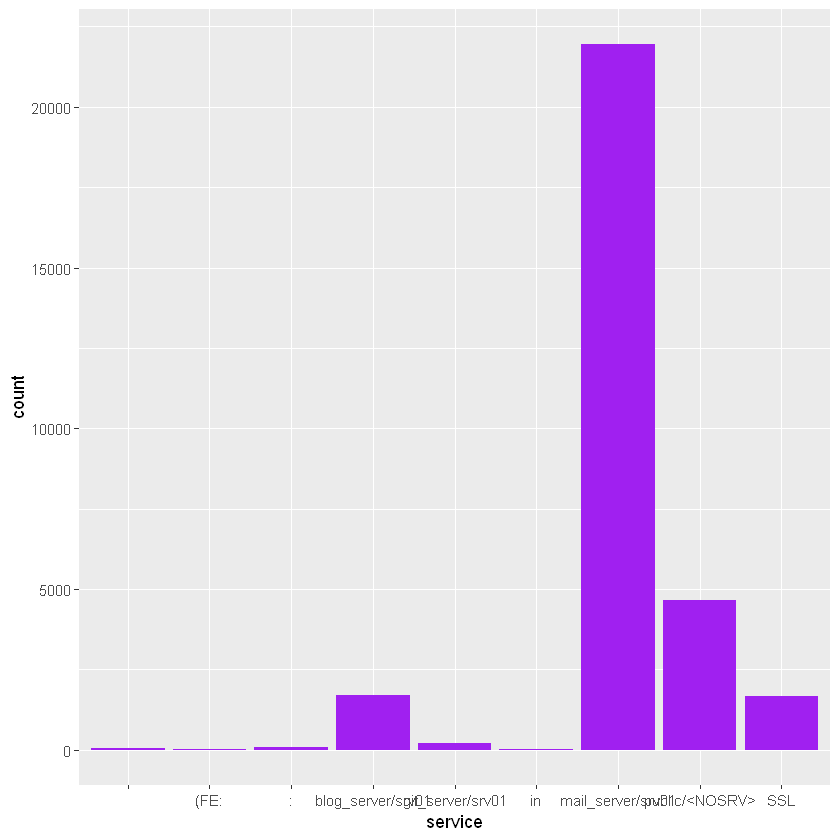

In [12]:
ggplot(data=sep, aes(x=service), options(repr.plot.width=15, repr.plot.height=4)) +
  geom_bar(fill = "purple")

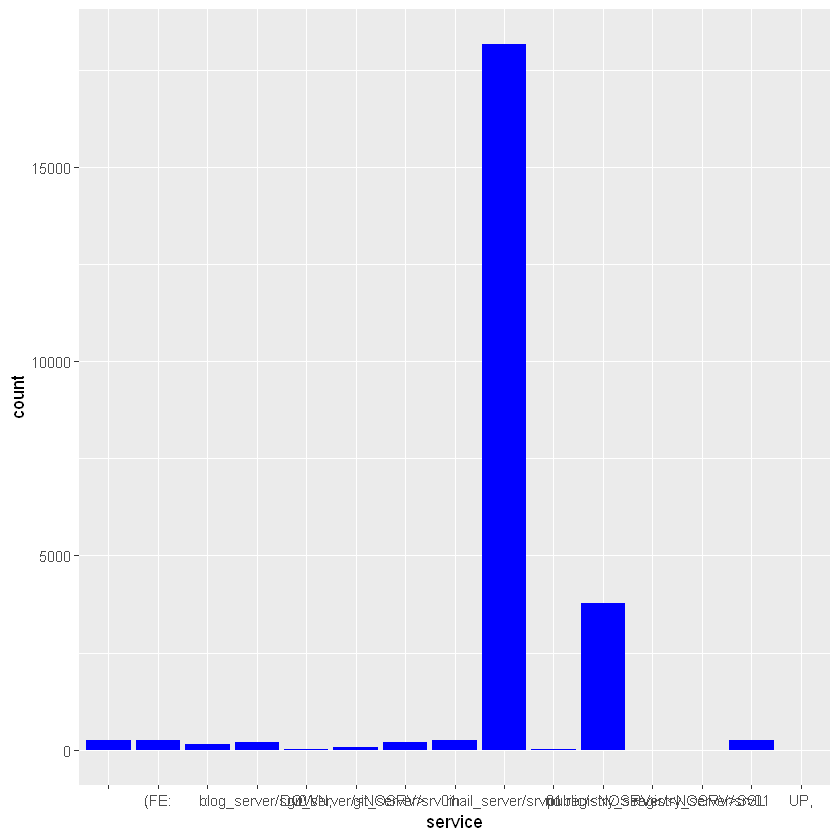

In [13]:
ggplot(data=oct, aes(x=service)) +
  geom_bar(fill = "blue") 

In [ ]:
#in case i need to load any images for reference
#fpath <- system.file('extdata/Leonardo_Birds.jpg',package='imager') 
#im <- load.image(fpath)
#plot(im)

In [14]:
(unique(sep[["action"]]))

[1] "\"GET"              ""                   "\"POST"            
 [4] "\"HEAD"             "<BADREQ>"           "\"SSTP_DUPLEX_POST"
 [7] "\"OPTIONS"          "workload"           "\"CONNECT"         
[10] "load"

In [15]:
(unique(oct[["action"]]))

[1] "\"GET"              "\"POST"             "<BADREQ>"          
 [4] ""                   "\"HEAD"             "workload"          
 [7] "section"            "'http-request"      "auth_okay_admin"   
[10] "referenced"         "\"DELETE"           "'tarpit',"         
[13] "group"              "duration:"          "active"            
[16] "\"OPTIONS"          "\"SSTP_DUPLEX_POST" "HELP"              
[19] "\"CONNECT"

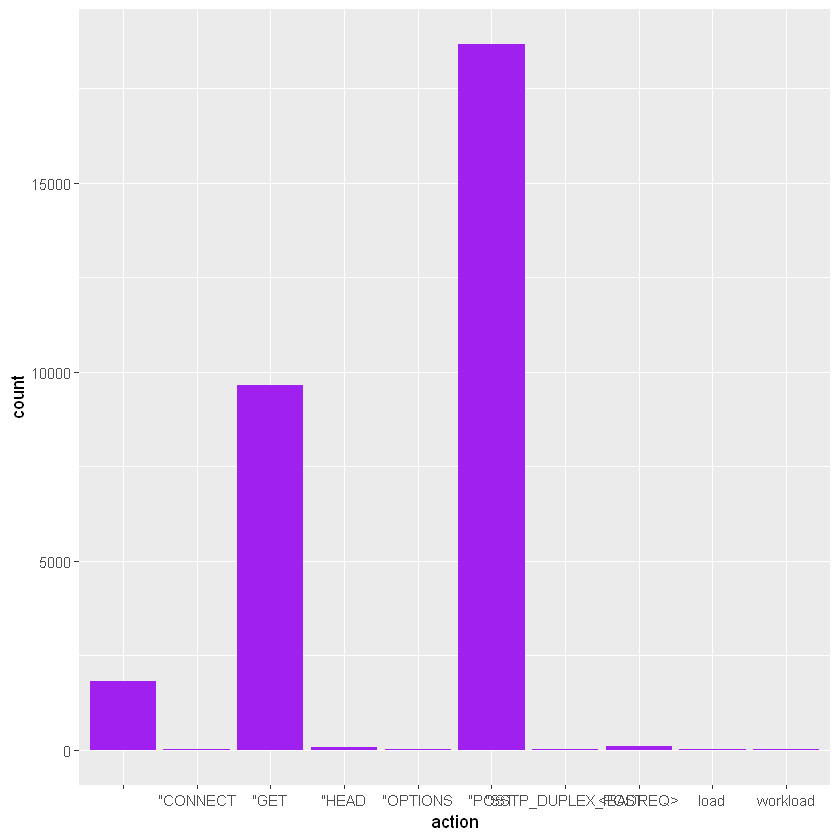

In [16]:
ggplot(data=sep, aes(x=action)) +
  geom_bar(fill = "purple")

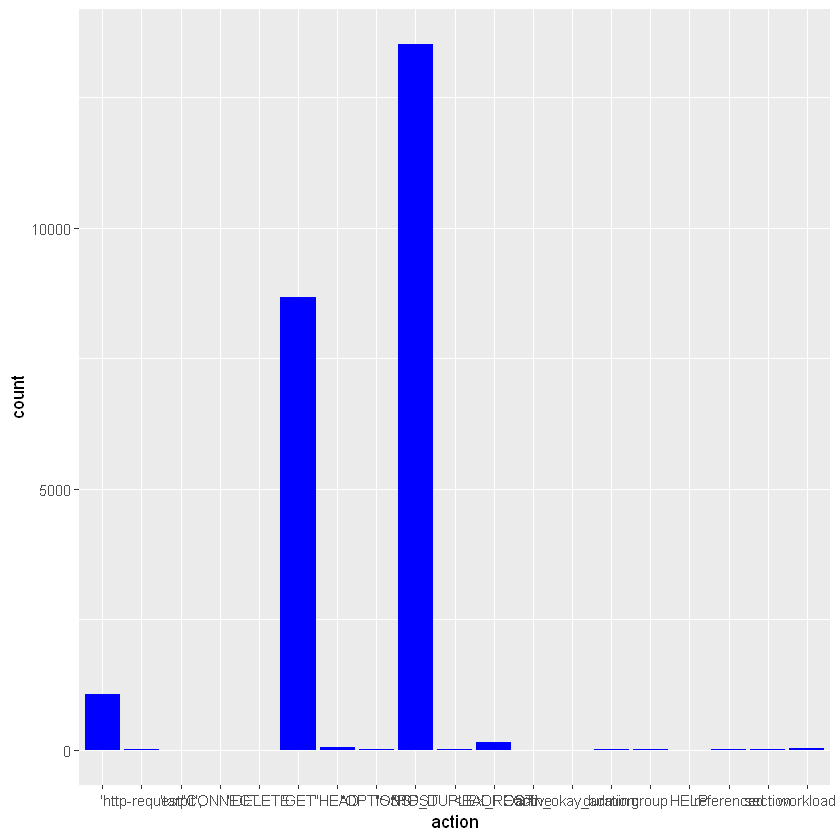

In [17]:
ggplot(data=oct, aes(x=action)) +
  geom_bar(fill = "blue")

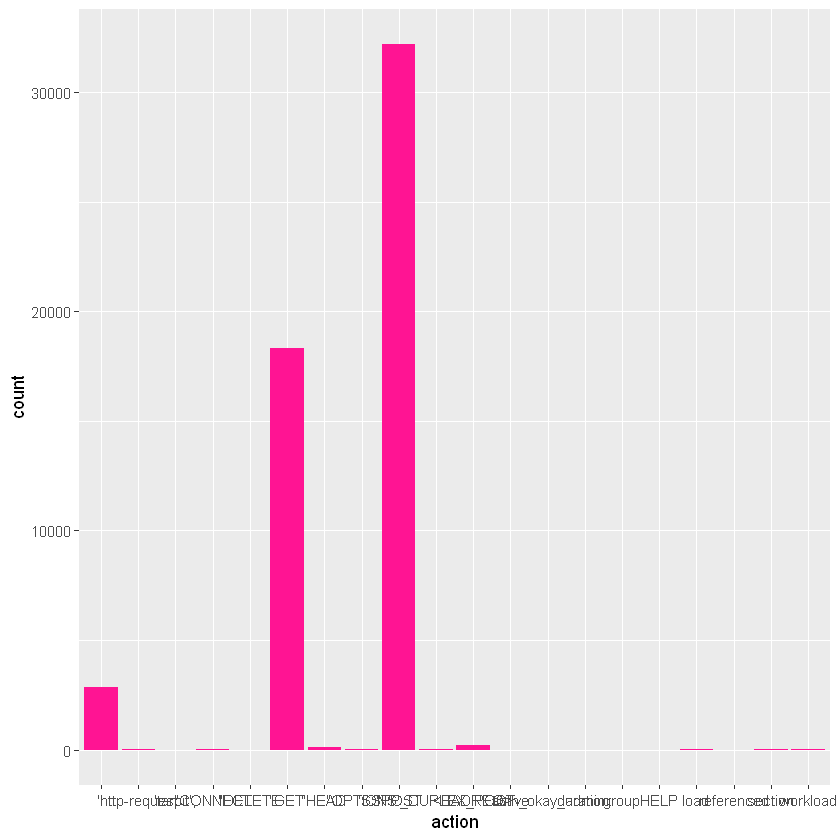

In [18]:
#test for correlations between "service" and "action"
#merge sep and oct
total <- rbind(sep, oct)
ggplot(data=total, aes(x=action)) +
  geom_bar(fill = "deeppink")

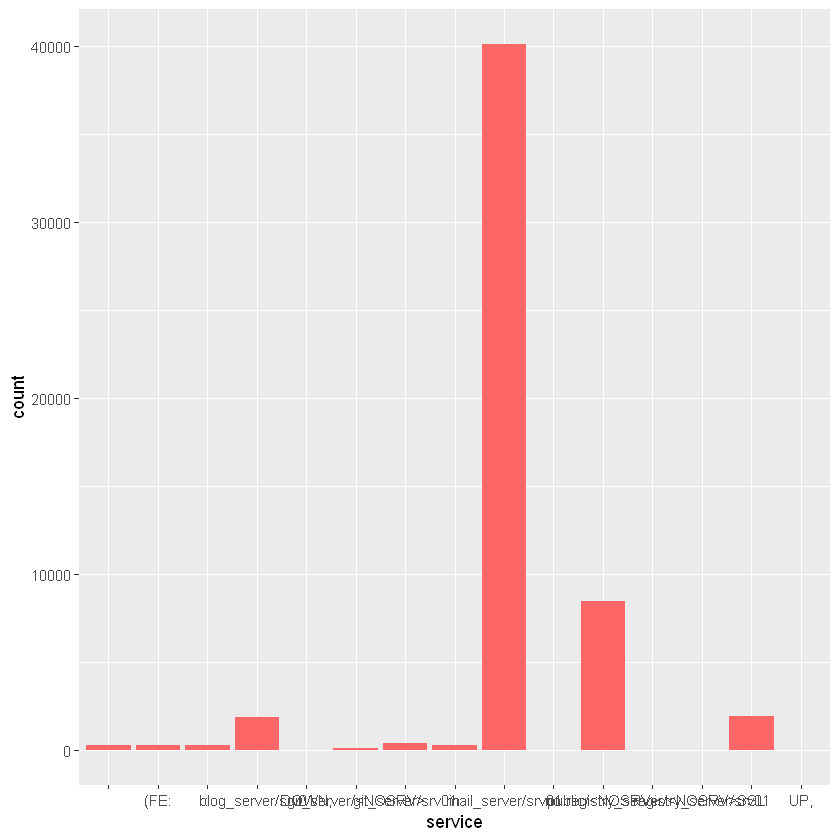

In [21]:
ggplot(data=total, aes(x=service)) +
  geom_bar(fill = "#FF6666")

In [116]:
nrow(total)

[1] 53874

In [117]:
#for starters, want to predict the public/<NOSRV> - ~7500 of these out of 53874
#the main one is mail service (legit), lets make an algorithm that correctly predicts public/<NOSRV> as the label 1 (realthreat), 
#everything else is 0 (no_threat) - as starting point
(unique(total[["service"]]))

[1] "public/<NOSRV>"          "SSL"                    
 [3] "mail_server/srv01"       "blog_server/srv01"      
 [5] "git_server/srv01"        ":"                      
 [7] ""                        "in"                     
 [9] "(FE:"                    "git_server/<NOSRV>"     
[11] "registry_server/<NOSRV>" "registry_server/srv01"  
[13] "DOWN,"                   "no"                     
[15] "UP,"

In [ ]:
#checking for correlation - errors, incorrect, need to come back to this alter after creating dummies

In [94]:
res <- cor.test(total$action, total$service, 
                    method = "pearson")
res

ERROR: Error in cor.test.default(total$action, total$service, method = "pearson"): 'x' must be a numeric vector


In [97]:
chi2 = chisq.test(total$month, total$service)
c(chi2$statistic, chi2$p.value)

Warning message in chisq.test(total$month, total$service):
"Chi-squared approximation may be incorrect"


X-squared           
 2523.458     0.000

In [ ]:
#!!!!!!!!!!!!!!!1come back to correlation testsing!!!!!!!!!!!!!!!!!

### Setup

In [127]:
head(total)

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,data1,data2,ignore1,ignore2,label1,seq2,seq3,action,note,http
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,Sep,23,12:06:14 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:06:14.331],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.0"""
2,Sep,23,12:11:03 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:11:01.638],public/2:,SSL,handshake,failure,,,,,,,,,
3,Sep,23,12:25:57 AM,cyberwise,haproxy[18755]:,170.82.48.12:42622,[23/Sep/2020:00:25:57.296],public/2:,SSL,handshake,failure,,,,,,,,,
4,Sep,23,12:48:33 AM,cyberwise,haproxy[18755]:,181.143.101.194:33327,[23/Sep/2020:00:48:33.326],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""POST",/cgi-bin/ViewLog.asp,"HTTP/1.1"""
5,Sep,23,12:55:20 AM,cyberwise,haproxy[18755]:,45.148.10.28:44932,[23/Sep/2020:00:55:20.249],public,public/<NOSRV>,-1/-1/-1/-1/0,503,213,-,-,SC--,1/1/0/0/0,0/0,"""GET",/config/getuser?index=0,"HTTP/1.1"""
6,Sep,23,12:58:48 AM,cyberwise,haproxy[18755]:,193.40.241.27:45505,[23/Sep/2020:00:58:47.771],public~,mail_server/srv01,0/0/1/284/286,200,842,-,-,--NN,1/1/0/0/0,0/0,"""POST",/?/Ajax/&q[]=/_4wXiFYfqwmL7Nwr2QroCHSM_NzyufG_GfkV-Fm-eF5HYhgDpoeVKOXBnvGiF_cEcq5ftapqlmnQkaIua8yULfJ9TgPwuKJ0dpU4SO00CWn7F1RTydBISZMqOXM114eAIyT-V40GsZEy_4veyksBqnKMSLP04o-GZC2ZR5JxpT79hOBWakhzWqi0ITJ8oMtm-dORkrojbYFlZ9VN98cJER0TLBlkgQFoRFIJDTRV50lriqq12BG46kOMwBRbxzuf-gc7xACmb9rXAGnKV4k02xWCv-DE1SMV35Khii79dDYSSa5WTRGQLlKYLDfU0nvsS1msyzxyAoCnZW1WBAu5cARNTzRTUEFtaxKeu_vhtxu54EyTeB5AVo2yUpMUzOtGrZrMhPER4mn6kf62CSd2mHQ/,"HTTP/1.1"""


In [22]:
df <- dummy_cols(total, select_columns = 'service')
head(df)
#this creates my label column "service_public/<NOSRV>" in df

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,⋯,service_git_server/<NOSRV>,service_git_server/srv01,service_in,service_mail_server/srv01,service_no,service_public/<NOSRV>,service_registry_server/<NOSRV>,service_registry_server/srv01,service_SSL,"service_UP,"
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,Sep,23,12:06:14 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:06:14.331],public,public/<NOSRV>,-1/-1/-1/-1/0,⋯,0,0,0,0,0,1,0,0,0,0
2,Sep,23,12:11:03 AM,cyberwise,haproxy[18755]:,185.156.73.64:61000,[23/Sep/2020:00:11:01.638],public/2:,SSL,handshake,⋯,0,0,0,0,0,0,0,0,1,0
3,Sep,23,12:25:57 AM,cyberwise,haproxy[18755]:,170.82.48.12:42622,[23/Sep/2020:00:25:57.296],public/2:,SSL,handshake,⋯,0,0,0,0,0,0,0,0,1,0
4,Sep,23,12:48:33 AM,cyberwise,haproxy[18755]:,181.143.101.194:33327,[23/Sep/2020:00:48:33.326],public,public/<NOSRV>,-1/-1/-1/-1/0,⋯,0,0,0,0,0,1,0,0,0,0
5,Sep,23,12:55:20 AM,cyberwise,haproxy[18755]:,45.148.10.28:44932,[23/Sep/2020:00:55:20.249],public,public/<NOSRV>,-1/-1/-1/-1/0,⋯,0,0,0,0,0,1,0,0,0,0
6,Sep,23,12:58:48 AM,cyberwise,haproxy[18755]:,193.40.241.27:45505,[23/Sep/2020:00:58:47.771],public~,mail_server/srv01,0/0/1/284/286,⋯,0,0,0,1,0,0,0,0,0,0


In [23]:
colnames(df)

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_:"                      
[23] "service_(FE:"                    "service_blog_server/srv01"      
[25] "service_DOWN,"                   "service_git_server/<NOSRV>"     
[27] "service_git_server/srv01"        "service_in"                     
[29] "service_mail_server/srv01"       "service_no"                     
[31] "service_public/<NOSRV>"          "service_registry_server/<NOSRV>"
[33] "service_registry_server/srv01"   "service_SSL"                    
[35] "service_UP,"

In [24]:
colnames(df)[colnames(df) == "service_public/<NOSRV>"] <- "threat"
colnames(df)
#i know how my binary label "threat" - now need a detector/classifier model
#hypothesis #1 - action type, repeated ipaddress, seq1, data1, data2, label1, seq2, seq3  could be correlated to label "threat"

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_:"                      
[23] "service_(FE:"                    "service_blog_server/srv01"      
[25] "service_DOWN,"                   "service_git_server/<NOSRV>"     
[27] "service_git_server/srv01"        "service_in"                     
[29] "service_mail_server/srv01"       "service_no"                     
[31] "threat"                          "service_registry_server/<NOSRV>"
[33] "service_registry_server/srv01"   "service_SSL"                    
[35] "service_UP,"

In [ ]:
#for purposes of DEMO, we will skip the detailed stat testing to eliminate variables and solidify model.  
#hypthosis # 2 - we we say out top features are action, seq1, data1, and data2 - along any repeated ipaddresses.  
#lets at least check for freq of unique ipaddresses b4 modeling

In [25]:
(unique(df[["ipaddress"]]))

[1] "185.156.73.64:61000"   "170.82.48.12:42622"    "181.143.101.194:33327"
    [4] "45.148.10.28:44932"    "193.40.241.27:45505"   "193.40.241.27:32747"  
    [7] "193.40.241.27:38056"   "176.113.115.214:47638" "176.113.115.214:45918"
   [10] "176.113.115.214:58324" "176.113.115.214:48350" "52.252.105.88:43524"  
   [13] "52.252.105.88:43554"   "197.232.48.155:37039"  "176.113.115.214:46422"
   [16] "42.228.33.179:37449"   "185.220.87.149:40416"  "193.40.241.27:64351"  
   [19] "83.97.20.252:33038"    "39.104.14.100:54058"   "39.104.14.100:55018"  
   [22] "39.104.14.100:42898"   "39.104.14.100:43890"   "168.196.202.220:9223" 
   [25] "168.196.202.220:9224"  "168.196.202.220:9228"  "193.40.241.27:34946"  
   [28] "193.40.241.27:62236"   "193.40.241.27:19824"   "167.71.102.95:46322"  
   [31] "176.113.115.214:53396" "202.83.42.165:30263"   "172.19.0.3:33136"     
   [34] "68.150.109.112:54726"  "176.113.115.214:34118" "5.199.139.93:42334"   
   [37] "27.216.49.142:56723"   "193.40.241.27:29301"   "37.112.108.18:10172"  
   [40] "80.82.68.117:37536"    "80.82.68.117:49744"    "193.40.241.27:27139"  
   [43] "193.40.241.27:43164"   "193.40.241.27:11263"   "193.40.241.27:1180"   
   [46] "31.179.232.65:37878"   "193.40.241.27:21772"   "86.57.80.209:37318"   
   [49] "193.40.241.27:31513"   "193.40.241.27:17050"   "193.40.241.27:56165"  
   [52] "193.40.241.27:46587"   "103.149.192.179:56613" "168.232.12.110:41918" 
   [55] "96.42.10.130:51786"    "193.40.241.27:36462"   "193.40.241.27:44933"  
   [58] "193.40.241.27:30643"   "193.40.241.27:6492"    "27.216.196.217:41755" 
   [61] "193.40.241.27:58653"   "193.40.241.27:39473"   "193.40.241.27:20955"  
   [64] "193.40.241.27:55126"   "193.40.241.27:65084"   "193.40.241.27:53018"  
   [67] "193.40.241.27:9858"    "193.40.241.27:64983"   "193.40.241.27:44214"  
   [70] "193.40.241.27:14684"   "193.40.241.27:46533"   "193.40.241.27:40699"  
   [73] "94.102.51.119:33796"   "193.40.241.27:20023"   "193.40.241.27:9332"   
   [76] "193.40.241.27:64945"   "193.40.241.27:25126"   "193.40.241.27:15753"  
   [79] "193.40.241.27:5123"    "193.40.241.27:17697"   "193.40.241.27:5582"   
   [82] "193.40.241.27:37701"   "193.40.241.27:47986"   "193.40.241.27:35581"  
   [85] "193.40.241.27:20528"   "193.40.241.27:35825"   "193.40.241.27:8468"   
   [88] "193.40.241.27:55120"   "193.40.241.27:30277"   "193.118.53.210:44790" 
   [91] "193.40.241.27:6471"    "193.40.241.27:10830"   "193.40.241.27:6681"   
   [94] "193.40.241.27:43223"   "193.40.241.27:22286"   "193.40.241.27:36551"  
   [97] "193.40.241.27:19420"   "193.40.241.27:22786"   "193.40.241.27:60104"  
  [100] "193.40.241.27:23835"   "193.40.241.27:22176"   "179.61.113.242:38863" 
  [103] "193.40.241.27:4929"    "167.248.133.33:60458"  "167.248.133.33:55162" 
  [106] "193.40.241.27:50387"   "193.40.241.27:48476"   "193.40.241.27:37673"  
  [109] "193.40.241.27:50657"   "193.40.241.27:45453"   "128.199.250.208:44128"
  [112] "128.199.250.208:1556"  "128.199.250.208:44224" "128.199.250.208:1658" 
  [115] "128.199.250.208:44322" "128.199.250.208:1736"  "128.199.250.208:44402"
  [118] "128.199.250.208:1818"  "128.199.250.208:44498" "128.199.250.208:1924" 
  [121] "128.199.250.208:44596" "128.199.250.208:2030"  "128.199.250.208:44694"
  [124] "128.199.250.208:2120"  "128.199.250.208:44892" "128.199.250.208:44922"
  [127] "128.199.250.208:44938" "128.199.250.208:2424"  "128.199.250.208:2440" 
  [130] "128.199.250.208:2464"  "128.199.250.208:45144" "128.199.250.208:2588" 
  [133] "192.35.168.160:49036"  "45.141.87.39:44319"    "45.141.87.39:50673"   
  [136] "94.102.51.119:35094"   "54.36.113.142:34608"   "54.36.113.142:34610"  
  [139] "90.190.105.175:58248"  "90.190.105.175:58305"  "90.190.105.175:58312" 
  [142] "90.190.105.175:58330"  "90.190.105.175:58351"  "90.190.105.175:58443" 
  [145] "90.190.105.175:58486"  "90.190.105.175:58488"  "90.190.105.175:58498" 
  [148] "90.190.105.175:58576"  "90.190.105.175:58832"  "90.190.105.175:58883" 
  [1

In [143]:
nrow(df)

[1] 53874

In [26]:
length(unique(df[["ipaddress"]]))
#out of ~53K total, only 44K ipaddresses are unique
#~10K are used repeatedly, lets check for the high-runners


[1] 44739

In [27]:
df <- transform(df, freq= ave(seq(nrow(df)), ipaddress, FUN=length))
df[order(-df$freq), ]
#!!!!Note - revist this!!!!

,month,day,time,source,proxy,ipaddress,timestamp,public,service,seq1,⋯,service_git_server.srv01,service_in,service_mail_server.srv01,service_no,threat,service_registry_server..NOSRV.,service_registry_server.srv01,service_SSL,service_UP.,freq
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
8018,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,public,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8019,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,public,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8020,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,mail_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8021,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,mail_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8022,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,git_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8023,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,git_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8024,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,blog_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8025,Sep,27,6:21:39 AM,cyberwise,haproxy[18754]:,Proxy,blog_server,started.,,,⋯,0,0,0,0,0,0,0,0,0,532
8034,Sep,27,6:21:39 AM,cyberwise,haproxy[18755]:,Proxy,public,stopped,(FE:,21621,⋯,0,0,0,0,0,0,0,0,0,532


In [28]:
count(df,ipaddress)

ipaddress,n
<chr>,<int>
[ALERT],148
[WARNING],102
1.193.177.125:4213,1
1.196.79.43:7222,1
1.199.152.182:5048,1
1.55.215.30:43806,1
1.55.215.30:43982,1
1.55.215.30:44132,1
1.68.220.27:11552,1


In [ ]:
# want to filter the ipadress field to only include the backend, Proxy, Server, Stopping, [Alert], and [Warning] - 
# - then create dummies for just these

In [43]:
df1 <- filter(df, ipaddress == "Proxy")
df2 <- filter(df, ipaddress == "backend")
df3 <- filter(df, ipaddress == "Server")
df4 <- filter(df, ipaddress == "Stopping")
df5 <- filter(df, ipaddress == "[Alert]")
df6 <- filter(df, ipaddress == "[Warning]")
#| ipaddress = "backend") #, ipaddress == "backend")
#sep <- filter(log1, month == "Sep")
#other <- filter(log1, month !="Oct", month != "Sep" )
new <- rbind(df1, df2, df3, df4, df5, df6)
nrow(new)

[1] 796

In [48]:
colnames(new)

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_."                      
[23] "service_.FE."                    "service_blog_server.srv01"      
[25] "service_DOWN."                   "service_git_server..NOSRV."     
[27] "service_git_server.srv01"        "service_in"                     
[29] "service_mail_server.srv01"       "service_no"                     
[31] "threat"                          "service_registry_server..NOSRV."
[33] "service_registry_server.srv01"   "service_SSL"                    
[35] "service_UP."                     "freq"

In [50]:
(unique(df[["action"]]))

[1] "\"GET"              ""                   "\"POST"            
 [4] "\"HEAD"             "<BADREQ>"           "\"SSTP_DUPLEX_POST"
 [7] "\"OPTIONS"          "workload"           "\"CONNECT"         
[10] "load"               "section"            "'http-request"     
[13] "auth_okay_admin"    "referenced"         "\"DELETE"          
[16] "'tarpit',"          "group"              "duration:"         
[19] "active"             "HELP"

In [51]:
(unique(new[["action"]]))

[1] ""          "duration:" "active"

In [53]:
# interesting, so this means that after filtering out some of the ipaddresses, the standard actions are no longer present.
# indicates cross-correlation , lets also check threat column

In [52]:
(unique(new[["threat"]]))
#ok, interesting, also indicates that filterting out some of the ipaddresses, i have also found correlattion to my "threat" label.
#since i combined df1 - df6 all together to form 'new', i can check everthing !"new", and remove ipaddress column.
# only focus on rules 9i.e. in notes, response, response code, etc.

[1] 0

In [75]:
(unique(new[["action"]]))

[1] ""          "duration:" "active"

In [74]:
df7 <- filter(df, ipaddress != "Proxy")
df7 <- filter(df7, ipaddress != "backend")
df7 <- filter(df7, ipaddress != "Server")
df7 <- filter(df7, ipaddress != "Stopping")
df7 <- filter(df7, ipaddress != "[Alert]")
df7 <- filter(df7, ipaddress != "[Warning]")
nrow(df7)
#df2 <- filter(df, ipaddress == "backend")
#df3 <- filter(df, ipaddress == "Server")
#df4 <- filter(df, ipaddress == "Stopping")
#df5 <- filter(df, ipaddress == "[Alert]")
#df6 <- filter(df, ipaddress == "[Warning]")

[1] 53078

In [77]:
(unique(df7[["action"]]))

[1] "\"GET"              ""                   "\"POST"            
 [4] "\"HEAD"             "<BADREQ>"           "\"SSTP_DUPLEX_POST"
 [7] "\"OPTIONS"          "workload"           "\"CONNECT"         
[10] "load"               "section"            "'http-request"     
[13] "auth_okay_admin"    "referenced"         "\"DELETE"          
[16] "'tarpit',"          "group"              "HELP"

In [78]:
(unique(df7[["threat"]]))

[1] 1 0

In [81]:
count(df7,threat)

threat,n
<int>,<int>
0,45445
1,8429


In [82]:
# simplify my input model
colnames(df7)

[1] "month"                           "day"                            
 [3] "time"                            "source"                         
 [5] "proxy"                           "ipaddress"                      
 [7] "timestamp"                       "public"                         
 [9] "service"                         "seq1"                           
[11] "data1"                           "data2"                          
[13] "ignore1"                         "ignore2"                        
[15] "label1"                          "seq2"                           
[17] "seq3"                            "action"                         
[19] "note"                            "http"                           
[21] "service_"                        "service_."                      
[23] "service_.FE."                    "service_blog_server.srv01"      
[25] "service_DOWN."                   "service_git_server..NOSRV."     
[27] "service_git_server.srv01"        "service_in"                     
[29] "service_mail_server.srv01"       "service_no"                     
[31] "threat"                          "service_registry_server..NOSRV."
[33] "service_registry_server.srv01"   "service_SSL"                    
[35] "service_UP."                     "freq"

In [95]:
# remove unused columns
df8 <- subset(df7, select = -c(1,2,3,4,5,6,7,8,9,13,14,21:30,32:37 ) )
colnames(df8)

[1] "seq1"   "data1"  "data2"  "label1" "seq2"   "seq3"   "action" "note"  
 [9] "http"   "threat"

In [97]:
head(df8)

,seq1,data1,data2,label1,seq2,seq3,action,note,http,threat
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>
1,-1/-1/-1/-1/0,503,213,SC--,1/1/0/0/0,0/0,"""GET",/,"HTTP/1.0""",1
2,handshake,failure,,,,,,,,0
3,handshake,failure,,,,,,,,0
4,-1/-1/-1/-1/0,503,213,SC--,1/1/0/0/0,0/0,"""POST",/cgi-bin/ViewLog.asp,"HTTP/1.1""",1
5,-1/-1/-1/-1/0,503,213,SC--,1/1/0/0/0,0/0,"""GET",/config/getuser?index=0,"HTTP/1.1""",1
6,0/0/1/284/286,200,842,--NN,1/1/0/0/0,0/0,"""POST",/?/Ajax/&q[]=/_4wXiFYfqwmL7Nwr2QroCHSM_NzyufG_GfkV-Fm-eF5HYhgDpoeVKOXBnvGiF_cEcq5ftapqlmnQkaIua8yULfJ9TgPwuKJ0dpU4SO00CWn7F1RTydBISZMqOXM114eAIyT-V40GsZEy_4veyksBqnKMSLP04o-GZC2ZR5JxpT79hOBWakhzWqi0ITJ8oMtm-dORkrojbYFlZ9VN98cJER0TLBlkgQFoRFIJDTRV50lriqq12BG46kOMwBRbxzuf-gc7xACmb9rXAGnKV4k02xWCv-DE1SMV35Khii79dDYSSa5WTRGQLlKYLDfU0nvsS1msyzxyAoCnZW1WBAu5cARNTzRTUEFtaxKeu_vhtxu54EyTeB5AVo2yUpMUzOtGrZrMhPER4mn6kf62CSd2mHQ/,"HTTP/1.1""",0


In [106]:
# create dummies on (seq1, data1, data2, label1, seq2, seq3), just start with "action" 
dummy <- dummy_cols(df8, select_columns = 'action')
colnames(dummy)

[1] "seq1"                      "data1"                    
 [3] "data2"                     "label1"                   
 [5] "seq2"                      "seq3"                     
 [7] "action"                    "note"                     
 [9] "http"                      "threat"                   
[11] "action_"                   "action_'http-request"     
[13] "action_'tarpit',"          "action_\"CONNECT"         
[15] "action_\"DELETE"           "action_\"GET"             
[17] "action_\"HEAD"             "action_\"OPTIONS"         
[19] "action_\"POST"             "action_\"SSTP_DUPLEX_POST"
[21] "action_<BADREQ>"           "action_auth_okay_admin"   
[23] "action_group"              "action_HELP"              
[25] "action_load"               "action_referenced"        
[27] "action_section"            "action_workload"

In [107]:
# create input of just action variables
input <- subset(dummy, select = -c(1:9))
colnames(input)

[1] "threat"                    "action_"                  
 [3] "action_'http-request"      "action_'tarpit',"         
 [5] "action_\"CONNECT"          "action_\"DELETE"          
 [7] "action_\"GET"              "action_\"HEAD"            
 [9] "action_\"OPTIONS"          "action_\"POST"            
[11] "action_\"SSTP_DUPLEX_POST" "action_<BADREQ>"          
[13] "action_auth_okay_admin"    "action_group"             
[15] "action_HELP"               "action_load"              
[17] "action_referenced"         "action_section"           
[19] "action_workload"

In [108]:
head(input)

,threat,action_,action_'http-request,"action_'tarpit',","action_""CONNECT","action_""DELETE","action_""GET","action_""HEAD","action_""OPTIONS","action_""POST","action_""SSTP_DUPLEX_POST",action_<BADREQ>,action_auth_okay_admin,action_group,action_HELP,action_load,action_referenced,action_section,action_workload
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# rules to focus on:
# Request for some .php file in wp which got error code as a response (e.G. uri="/new/wp-admin/install.php?step=1")
# Path traversal in uri (e.G. uri="/wp-content/plugins/image-export/download.php?file=../../../wp-config.php")

# GET reqeust some .php file in wp which got error code as a response
# Path traversal in uri
# POST request without 200 response code
# can assume all NOSRV line are bad

threat,n
<int>,<int>
0,45445
1,8429


### Modeling (choice of final algo TBD, binary classification with a few features, so will try SVM algo first)

In [117]:
set.seed(555)

In [118]:
# test train split
data1 = sort(sample(nrow(input), nrow(input)*.7))

#creating training data set by selecting the output row values
train<-input[data1,]

#creating test data set by not selecting the output row values
test<-input[-data1,]

In [127]:
x <- subset(train, select = -threat)
y <- subset(train, select = threat)
testx <- subset(test, select = -threat)
testy <- subset(test, select = threat)

In [122]:
model <- svm(x, y)

In [123]:
print(model)


Call:
svm.default(x = x, y = y)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05555556 
    epsilon:  0.1 


Number of Support Vectors:  11258



In [124]:
summary(model)


Call:
svm.default(x = x, y = y)


Parameters:
   SVM-Type:  eps-regression 
 SVM-Kernel:  radial 
       cost:  1 
      gamma:  0.05555556 
    epsilon:  0.1 


Number of Support Vectors:  11258






### Prediction

In [129]:
# test with test data
pred <- predict(model, testx)

### Validation

In [131]:
# Check accuracy:
tab1 <- table(pred, testy)
#confusionMatrix(tab1)

ERROR: Error in table(pred, testy): all arguments must have the same length


### Final Prep / Deployment